In [116]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.21.3.


In [117]:
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence


In [118]:
import pandas as pd
from pandas.plotting import scatter_matrix

import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix, r2_score, classification_report

import math

from collections import defaultdict

In [119]:
file = "/Users/lszczyrba/Documents/Research/Projects/PR_Housing/Data/master_df_20191122.xlsx"
data = pd.read_excel(file)
df_master = pd.DataFrame(data).set_index('FIPS')

In [120]:
print(df_master.columns)

Index(['PropSFHA', 'AveDepth', 'PropDG', 'MaxDepth', 'AveLS', 'HurTrack',
       'PeakGust', 'MaxSusta', 'SpecCom', 'STRVI_1', 'SEVI_1', 'STR_SEVI_1',
       'SOVI_1', 'STRVI_2', 'SEVI_2', 'SOVI_2', 'CDC_T1', 'CDC_T2', 'CDC_T3',
       'CDC_T4', 'CDC_Tot', 'O_IND', 'R_IND', 'R_I_NO0', 'R_I_NOO',
       'R_I_NO0_NO', 'CAT_3Q', 'CAT_4Q', 'Ex_Q4_c', 'COUNT__Y', 'R_DES',
       'R_AFF'],
      dtype='object')


In [49]:
# df_master

In [6]:
def choose_data(df_master, feature_list, target_list):
    choices = feature_list + target_list
    df = df_master[choices].copy()
    df.dropna(inplace = True)
    return df

In [121]:
# EXAMPLE:
feature_list = ['PropSFHA', 'AveDepth', 'PropDG', 'MaxDepth', 'AveLS', 'HurTrack',
               'PeakGust', 'MaxSusta', 'SpecCom', 'STRVI_1', 'SEVI_1', 'STR_SEVI_1','SOVI_1', 
               'CDC_T1', 'CDC_T2', 'CDC_T3', 'CDC_T4', 'CDC_Tot']
target_list = ['R_IND']

df = choose_data(df_master, feature_list, target_list)

In [122]:
def partition_data(df, target_str):
    y = df[target_str]
    df_x = df.drop(target_str, axis = 1)
    return y, df_x

In [123]:
# EXAMPLE:
target_str = 'R_IND'
y, df_x = partition_data(df, target_str)

In [124]:
def bin_target(y, n_bins, label):
    y_binned = pd.qcut(y, q=n_bins, labels = label)
    return y_binned

In [125]:
# EXAMPLE:
y_binned = bin_target(y,4, [0,1,2,3])

In [126]:
def split_the_data(df_x, y):
    x_train, x_test, y_train, y_test = train_test_split(df_x, y, 
                                                        test_size=0.3, 
                                                        random_state=42,
                                                        stratify = y_binned)
    return x_train, x_test, y_train, y_test

In [127]:
# Careful of Random State
# Change y_binned to y if categorical
# EXAMPLE:
x_train, x_test, y_train, y_test = split_the_data(df_x, y)

### Tune

In [132]:
#Choose all predictors except target & IDcols
# predictors = [x for x in x_train]
param_test1 = {'n_estimators':range(20,201,5)}
gsearch1 = GridSearchCV(estimator = GradientBoostingRegressor(loss = 'lad',
                                                             learning_rate=0.1, 
                                                              min_samples_split=2,
                                                              min_samples_leaf=1,
                                                              max_depth=5,
                                                              max_features='auto',
                                                              subsample=0.9,
                                                              random_state=42), 
param_grid = param_test1, n_jobs=4,iid=False, cv=5)

gsearch1.fit(x_train,y_train)

gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([ 0.06241975,  0.07451797,  0.08533492,  0.10005717,  0.10867362,
          0.11990209,  0.13176928,  0.14431357,  0.17565198,  0.17615714,
          0.19070067,  0.19482021,  0.20771103,  0.23505239,  0.23188262,
          0.23809018,  0.25165854,  0.26099968,  0.27014661,  0.28692732,
          0.29759254,  0.32774272,  0.33504848,  0.34223399,  0.34020619,
          0.36227379,  0.37122898,  0.38536744,  0.40622697,  0.42731705,
          0.44416018,  0.44392338,  0.45308766,  0.48277721,  0.48635921,
          0.48855162,  0.491431  ]),
  'std_fit_time': array([ 0.0029317 ,  0.00423751,  0.00241136,  0.00295299,  0.0030829 ,
          0.00230387,  0.00238795,  0.00481857,  0.00490613,  0.00558077,
          0.00206585,  0.00749578,  0.00420236,  0.00739928,  0.0082793 ,
          0.0048664 ,  0.00761216,  0.00567503,  0.00424012,  0.00998815,
          0.00374933,  0.00423254,  0.01728113,  0.00335801,  0.00925804,
          0.01374194,  0.01179499,  0.0080

### Plot ideal trees

In [133]:
score = pd.DataFrame(gsearch1.cv_results_)

In [134]:
score['n_tree'] = range(20,201,5)

In [135]:
score.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_n_estimators', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score', 'n_tree'],
      dtype='object')

(array([ 0.09,  0.1 ,  0.11,  0.12,  0.13,  0.14,  0.15,  0.16]),
 <a list of 8 Text yticklabel objects>)

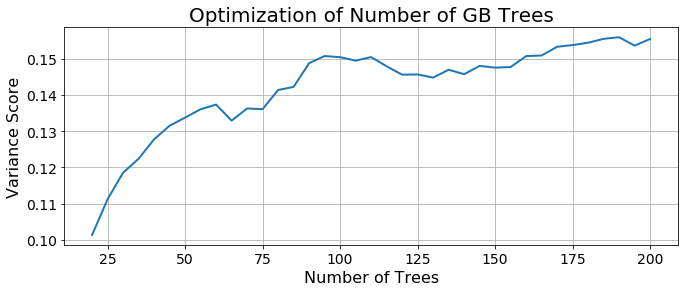

In [136]:
fig, ax = plt.subplots(1, 1, figsize=(11, 4))
ax.plot(score['n_tree'], score['mean_test_score'], linewidth = 2)
ax.set_title('Optimization of Number of GB Trees', fontsize=20)
ax.grid(True)

ax.set_xlabel('Number of Trees', fontsize=16)
ax.set_ylabel('Variance Score', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# plt.savefig('Tree_optimization.png', dpi=600, bbox_inches = "tight")

In [28]:
#Choose all predictors except target & IDcols
# predictors = [x for x in x_train]
param_test1 = {'n_estimators':range(20,501,5)}
treeplot = GridSearchCV(estimator = GradientBoostingRegressor(loss = 'lad',
                                                             learning_rate=0.1, 
                                                              min_samples_split=2,
                                                              min_samples_leaf=1,
                                                              max_depth=5,
                                                              max_features='auto',
                                                              subsample=0.9,
                                                              random_state=42), 
param_grid = param_test1,scoring='neg_mean_absolute_error', n_jobs=4,iid=False, cv=5)

treeplot.fit(x_train,y_train)

treeplot.cv_results_, treeplot.best_params_, treeplot.best_score_

({'mean_fit_time': array([ 0.05846872,  0.06617637,  0.06860538,  0.07747078,  0.08641062,
          0.09591208,  0.10978637,  0.12156892,  0.12605352,  0.1323225 ,
          0.14557695,  0.14898343,  0.16218085,  0.17016864,  0.17340269,
          0.1810627 ,  0.19083643,  0.20145612,  0.21211104,  0.22216096,
          0.23590231,  0.2476748 ,  0.25012016,  0.29983373,  0.3753933 ,
          0.34001384,  0.28617587,  0.30438147,  0.36017761,  0.37003298,
          0.33535161,  0.33765936,  0.33939457,  0.34982791,  0.36975422,
          0.38334231,  0.39091091,  0.43622208,  0.38898883,  0.40065408,
          0.40817404,  0.42970181,  0.44639444,  0.4552701 ,  0.51437821,
          0.66355567,  0.67469945,  0.52197943,  0.49173436,  0.53486319,
          0.60510621,  0.58393002,  0.75948315,  0.65078344,  0.78335199,
          0.71733232,  0.58695712,  0.69642119,  0.61236668,  0.69680047,
          0.64413342,  0.7181778 ,  0.69957328,  0.74376526,  0.72802343,
          0.75399065,

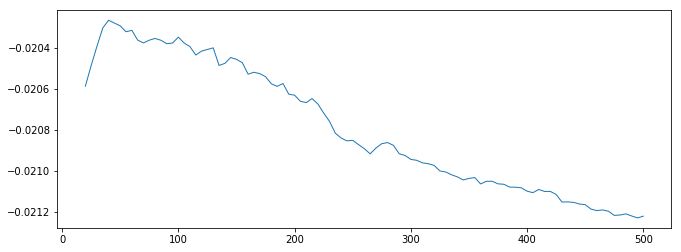

In [31]:
score = pd.DataFrame(treeplot.cv_results_)
score['n_tree'] = range(20,501,5)


fig, ax = plt.subplots(1, 1, figsize=(11, 4))
ax.plot(score['n_tree'], score['mean_test_score'], linewidth = 1)
# ax.set_title('Non-Tidal Component by FFT - Chesapeake Bay Bridge Tunnel', fontsize=20)
# #ax.set_xlabel('Date', fontsize=16)
# ax.set_ylabel('Water Elevation (m)', fontsize=16)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)

### Tune

In [137]:
param_test2 = {'max_depth':range(2,16,1), 'min_samples_split':range(2,20,1)}
gsearch2 = GridSearchCV(estimator = GradientBoostingRegressor(loss = 'lad',
                                                              learning_rate=0.1, 
                                                              n_estimators=190, 
                                                              max_features='sqrt', 
                                                              subsample=0.8, 
                                                              random_state=42), 
param_grid = param_test2,n_jobs=4,iid=False, cv=5)

gsearch2.fit(x_train,y_train)

gsearch2.cv_results_, 
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 8, 'min_samples_split': 8}, 0.21287239243866915)

### Depth plot

In [33]:
param_test2 = {'max_depth':range(2,50,1)}
gsearch2 = GridSearchCV(estimator = GradientBoostingRegressor(loss = 'lad',
                                                              learning_rate=0.1, 
                                                              n_estimators=100, 
                                                              max_features='sqrt', 
                                                              subsample=0.8, 
                                                              random_state=42), 
param_grid = param_test2, n_jobs=4,iid=False, cv=5)

gsearch2.fit(x_train,y_train)

gsearch2.cv_results_, 
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 14}, 0.23956849825819013)

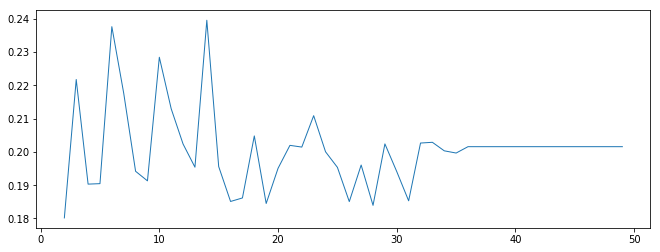

In [34]:
score = pd.DataFrame(gsearch2.cv_results_)
score['depth'] = range(2,50,1)


fig, ax = plt.subplots(1, 1, figsize=(11, 4))
ax.plot(score['depth'], score['mean_test_score'], linewidth = 1)
# ax.set_title('Non-Tidal Component by FFT - Chesapeake Bay Bridge Tunnel', fontsize=20)
# #ax.set_xlabel('Date', fontsize=16)
# ax.set_ylabel('Water Elevation (m)', fontsize=16)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)

### Tune

In [35]:
param_test3 = {'min_samples_split':range(2,20,1), 'min_samples_leaf':range(2,20,1)}
gsearch3 = GridSearchCV(estimator = GradientBoostingRegressor(loss = 'lad',
                                                              learning_rate=0.1, 
                                                              n_estimators=190,
                                                              max_depth=8,
                                                              max_features='sqrt', 
                                                              subsample=0.8, 
                                                              random_state=42), 
param_grid = param_test3,n_jobs=4,iid=False, cv=5)
gsearch3.fit(x_train, y_train)

#gsearch3.cv_results_, 
gsearch3.best_params_, gsearch3.best_score_

({'min_samples_leaf': 4, 'min_samples_split': 16}, 0.25015366065708949)

In [36]:
param_test4 = {'max_features':range(1,9,1)}
gsearch4 = GridSearchCV(estimator = GradientBoostingRegressor(loss = 'lad',
                                                              learning_rate=0.1, 
                                                               n_estimators=190,
                                                               max_depth=8, 
                                                               min_samples_split=8, 
                                                               min_samples_leaf=4, 
                                                               subsample=0.8, 
                                                               random_state=42),
param_grid = param_test4, n_jobs=4,iid=False, cv=5)
gsearch4.fit(x_train, y_train)
#gsearch4.cv_results_, 
gsearch4.best_params_, gsearch4.best_score_

({'max_features': 3}, 0.25015366065708949)

In [37]:
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = GradientBoostingRegressor(loss = 'lad',
                                                              learning_rate=0.1, 
                                                               n_estimators=100,
                                                               max_depth=14, 
                                                               min_samples_split=16, 
                                                               min_samples_leaf=4, 
                                                               #subsample=0.8, 
                                                               random_state=42,
                                                              max_features=3),
param_grid = param_test5, n_jobs=4,iid=False, cv=5)
tuned1 = gsearch5.fit(x_train, y_train)
#gsearch5.cv_results_, 
gsearch5.best_params_, gsearch5.best_score_

({'subsample': 0.8}, 0.25015366065708949)

In [38]:
# predictors = [x for x in x_train]
gbm_tuned_1 = GradientBoostingRegressor(loss = 'lad',
                                        learning_rate=0.05, 
                                        n_estimators=200,
                                        max_depth=14, 
                                        min_samples_split=16, 
                                        min_samples_leaf=4, 
                                        #subsample=0.8, 
                                        random_state=42,
                                        max_features=3)
tuned2 = gbm_tuned_1.fit(x_train, y_train)

In [228]:
tuned2.get_params

<bound method BaseEstimator.get_params of GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='lad', max_depth=12, max_features=3,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=9,
             min_samples_split=19, min_weight_fraction_leaf=0.0,
             n_estimators=140, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)>

# Optimization Results

### R_In_No0

In [50]:
# IDEAL1 (SCORE 70%/15%)

gbrt = GradientBoostingRegressor(loss = 'ls',
                                #alpha = .4,
                                learning_rate = 0.05,
                                n_estimators=175,
                                subsample = 0.78,
                                criterion = "friedman_mse",
                                min_samples_split = 2,
                                min_samples_leaf = 11,
                                random_state = 42,
                                max_depth = 6,
                                max_features = 1)
IDEAL1 = gbrt.fit(x_train, y_train)

In [51]:
#IDEAL2 (SCORE 80%/ 16%)

gbrt = GradientBoostingRegressor(loss = 'lad',
                                #alpha = .4,
                                learning_rate = 0.1,
                                n_estimators=500,
                                subsample = 0.9,
                                criterion = "friedman_mse",
                                min_samples_split = 2,
                                min_samples_leaf = 1,
                                random_state = 42,
                                max_depth = 5,
                                max_features = 'auto')
IDEAL2 = gbrt.fit(x_train, y_train)

In [52]:
# IDEAL 3 (SCORE 57%/13%)
gbm_tuned_1 = GradientBoostingRegressor(loss = 'lad',
                                        learning_rate=0.05, 
                                        n_estimators=140,
                                        max_depth=12, 
                                        min_samples_split=19, 
                                        min_samples_leaf=9, 
                                        #subsample=0.8, 
                                        random_state=42,
                                        max_features=3)
IDEAL3 = gbm_tuned_1.fit(x_train, y_train)

In [124]:
# tuned_model.fit(x_train, y_train)

### Evaluate

In [15]:
def predict(model, x_train, x_test):   
    pred_test = model.predict(x_test)
    pred_train = model.predict(x_train)
    
    return pred_train, pred_test

In [53]:
pred_train, pred_test = predict(IDEAL1, x_train, x_test)

In [54]:
def variance_score(model, x_train, y_train, x_test, y_test):
    r_train = model.score(x_train, y_train)
    r_test = model.score(x_test, y_test)
    
    return r_train, r_test

In [55]:
r_train, r_test = variance_score(IDEAL1, x_train, y_train, x_test, y_test)

In [56]:
r_test

0.14648729724772658

In [57]:
def evaluate_regression(pred_train, pred_test, y_train, y_test):
    r_train = r2_score(y_train, pred_train)
    print('The training r-squared score is {}'.format(r_train))
    r_test = r2_score(y_test, pred_test)
    print('The testing r-squared score is {}'.format(r_test))
    meanabserrors_train = np.mean(abs(pred_train - y_train))
    print('The training mean absolute error is {}'.format(meanabserrors_train))
    meanabserrors_test = np.mean(abs(pred_test - y_test))
    print('The testing mean absolute error is {}'.format(meanabserrors_test))
    rmse = math.sqrt(mean_squared_error(y_test, pred_test))
    print('The root mean square error is {}'.format(rmse))
    mse = mean_squared_error(y_test, pred_test)
    print('The mean square error is {}'.format(mse))
    errors = pred_test - y_test
    meanerror = np.mean(errors)
    print('The mean error is {}'.format(meanerror))
    return errors

In [58]:
# EXAMPLE
errors = evaluate_regression(pred_train, pred_test, y_train, y_test)

The training r-squared score is 0.715236228516414
The testing r-squared score is 0.14648729724772658
The training mean absolute error is 0.012686334684541764
The testing mean absolute error is 0.02120427827201586
The root mean square error is 0.029231397812868938
The mean square error is 0.000854474618094199
The mean error is 0.0003778827163952153


In [71]:
def plot_predictions(y_test, pred, Title):
    df_predictions = pd.DataFrame(y_test)
    df_predictions['Pred'] = pred
    X = df_predictions.iloc[:, 0].values.reshape(-1, 1)
    Y = df_predictions.iloc[:, 1].values.reshape(-1, 1)
    fig, ax = plt.subplots()
    ax.scatter(X, Y, color='maroon')
    line = mlines.Line2D([0, 1], [0, 1], color='orange')
    transform = ax.transAxes
    line.set_transform(transform)
    ax.add_line(line)
    ax.set_xlabel(ax.get_xlabel(), fontsize = 18)
    ax.set_ylabel(ax.get_ylabel(), fontsize = 18)
    ax.tick_params(axis='both', which='major', labelsize=15)
    plt.grid(True)
    plt.xlabel("Damage Index")
    plt.ylabel("Precited Damage Index")
    plt.xlim(0, 0.2)
    plt.ylim(0, 0.2)
    plt.title('Model Evaluation -' +  Title, fontsize = 20)
   # plt.savefig('GB_train_eval.png', dpi=600, bbox_inches = "tight")
    plt.show()

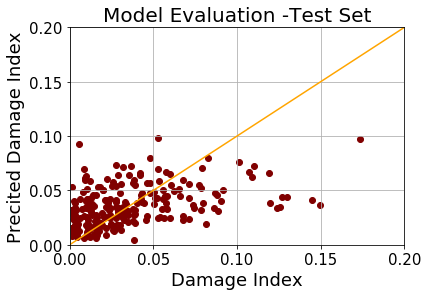

In [70]:
# EXAMPLE
plt.rcParams["figure.figsize"] = (6,4)
Title = 'Test Set'
plot_predictions(y_test, pred_test, Title)

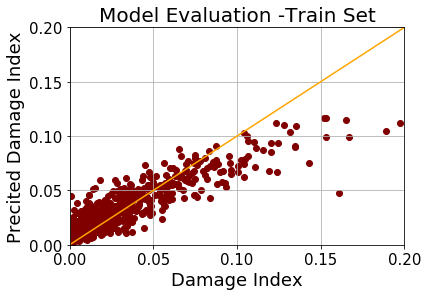

In [72]:
Title = 'Train Set'
plot_predictions(y_train, pred_train, Title)

In [62]:
x_train.columns

Index(['PropSFHA', 'PropDG', 'AveLS', 'HurTrack', 'PeakGust', 'StrVI', 'SeVI',
       'AveDepth', 'PropSComm'],
      dtype='object')

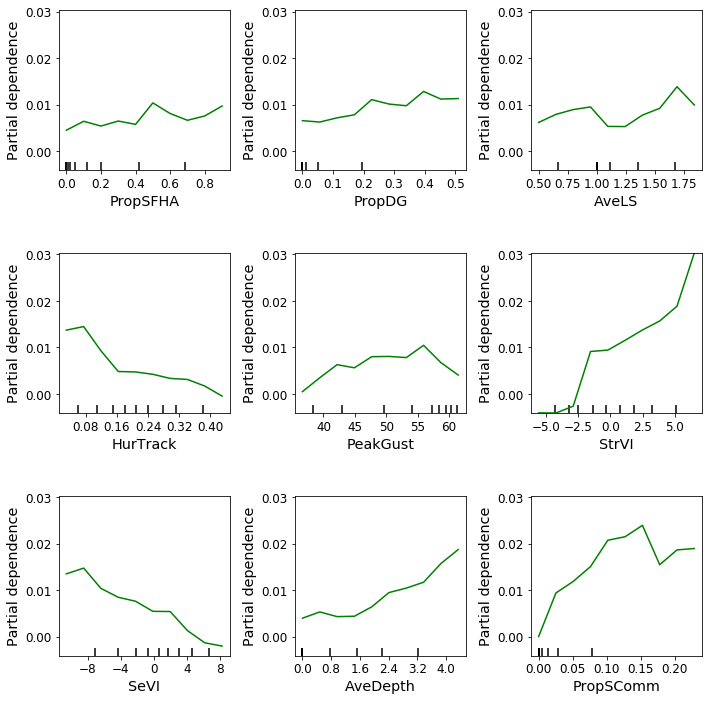

In [83]:
plt.rcParams["figure.figsize"] = (10,10)
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
plt.rcParams.update(params)


#plt.subplots(nrows=3,ncols=3, sharey=True)
fig = plot_partial_dependence(IDEAL2, 
                        x_train, 
                        [0,1,2,3,4,5,6,7,8], 
                        feature_names =['PropSFHA', 'PropDG', 'AveLS', 'HurTrack', 'PeakGust', 'StrVI', 'SeVI','AveDepth', 'PropSComm'], 
                        grid_resolution=10, 
                        #n_cols=2
                       ) 

plt.tight_layout(h_pad=3,w_pad=1)

plt.savefig('partialdependence.png', dpi=400, bbox_inches = "tight")



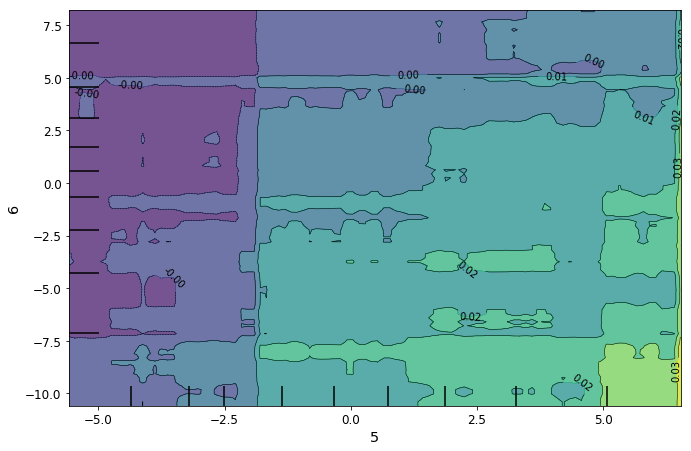

In [90]:
fig = plot_partial_dependence(IDEAL2, x_train, [(5,6)]) 

In [29]:
from pycebox.ice import ice, ice_plot

In [31]:
forty_ice_df = ice(data=x_train, column='HurTrack', 
                   predict=IDEAL2.predict)

In [33]:
cmap2 = plt.get_cmap('OrRd')

In [44]:
wt_vals = forty_ice_df.columns.get_level_values('PeakGust').values
sm = plt.cm.ScalarMappable(cmap=cmap2, 
                           norm=plt.Normalize(vmin=wt_vals.min(), 
                                              vmax=wt_vals.max()))
sm._A = []

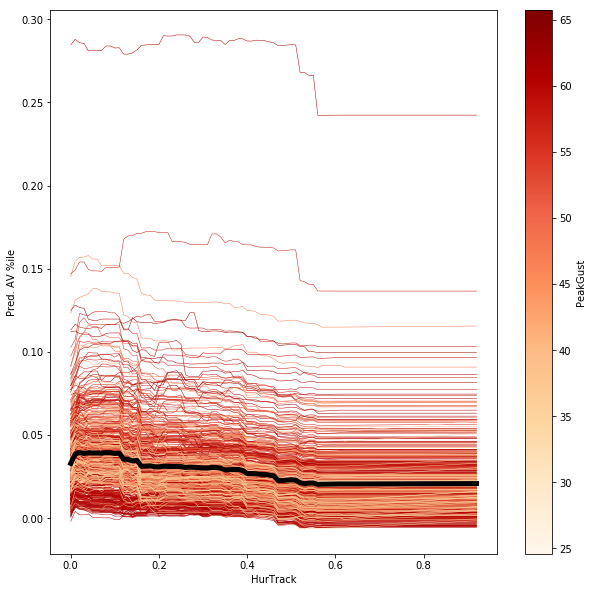

In [47]:
ice_plot(forty_ice_df, linewidth=.5, color_by='PeakGust', cmap=cmap2, plot_pdp=True, 
         pdp_kwargs={'c': 'k', 'linewidth': 5})
plt.colorbar(sm, label='PeakGust')
plt.ylabel('Pred. AV %ile')
plt.xlabel('HurTrack');

In [480]:
def calc_gini_importances(x_train, model):
    importances = model.feature_importances_
    importances_df = pd.DataFrame(importances, x_train.columns,
                                  columns=['Importance']).sort_values('Importance',
                                  ascending=False)
    importances_df.reset_index(inplace=True)
    importances_df.rename(columns={'index':'Feature'}, inplace=True)
    return importances_df


In [481]:
# indicate if reg_model or class_model
# EXAMPLE
df_gini_importances = calc_gini_importances(x_train, gbrt)

In [482]:
def gini_importance_plot(df_gini_importances):
    df_gini_importances.sort_values('Importance', ascending=False).plot.bar('Feature',
                                                                            'Importance', 
                                                                            color='maroon', 
                                                                            legend = False)
    plt.title("Feature Importances", fontsize = 25)
    plt.ylabel('Importance', fontsize = 16)
    plt.xlabel('')
    plt.xticks(fontsize = 16, rotation = 45, ha='right')
    plt.yticks(fontsize = 14)
#     plt.savefig('giniimportance.png', dpi=600, bbox_inches = "tight")
    


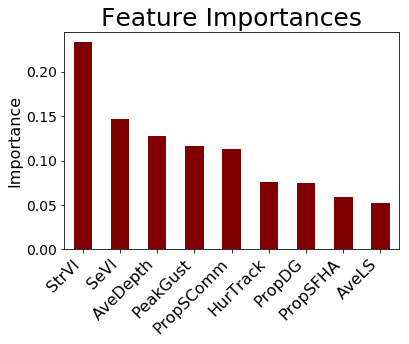

In [483]:
# EXAMPLE
gini_importance_plot(df_gini_importances)

In [484]:
def calc_permutation_importance(criterion, model, df_x, y):
    features = df_x.columns.values
    X = df_x.as_matrix()
    Y = y.as_matrix()
    scores = defaultdict(list)
    rf = model
    for train_idx, test_idx in ShuffleSplit(len(X), 100, .3, random_state=42): #number of splits, absolute number of test samples, proportion of data in train split
        X_train, X_test = X[train_idx], X[test_idx] #Random permutation cross-validator, Yields indices to split data into training and test sets.
        Y_train, Y_test = Y[train_idx], Y[test_idx]
        r = rf.fit(X_train, Y_train)
        acc = criterion(Y_test, rf.predict(X_test))
        for i in range(X.shape[1]): #The shape attribute for numpy arrays returns the dimensions of the array. If Y has n rows and m columns, then Y.shape is (n,m). So Y.shape[0] is n.
            X_t = X_test.copy()
            np.random.seed(42)
            np.random.shuffle(X_t[:, i]) #rearranging randomly
            shuff_acc = criterion(Y_test, rf.predict(X_t)) 
            scores[features[i]].append((acc-shuff_acc)/acc) #change in importance, actual - shuffled/actual, this is percent error        
    mda_features = [f for f in scores.keys()]
    mda_importance = [(np.mean(score)) for score in scores.values()] #average over all the shuffled permutations
    mda_indices = np.argsort(mda_importance)
    return mda_features, mda_importance, mda_indices

In [485]:
#EXAMPLE
#criterion can be r2_score or mean_squared_error
#should be MSE i think

criterion = mean_squared_error
mda_features, mda_importance, mda_indices = calc_permutation_importance(criterion, gbrt, df_x, y)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [486]:
def permutation_importance_plot(mda_features, mda_importance):
    df_perm_FI = pd.DataFrame({'Feature':mda_features, 'Importance':[abs(number) for number in mda_importance]})
    df_perm_FI.sort_values('Importance', ascending=False).plot.bar('Feature',
                                                                   'Importance', 
                                                                    color='maroon', 
                                                                    legend = False)
    plt.title("Feature Importances", fontsize = 30)
    plt.ylabel('Importance')
    plt.xlabel('')
    plt.xticks(fontsize = 12, rotation = 45, ha='right')
    plt.savefig('permutimportance.png', dpi=600, bbox_inches = "tight")

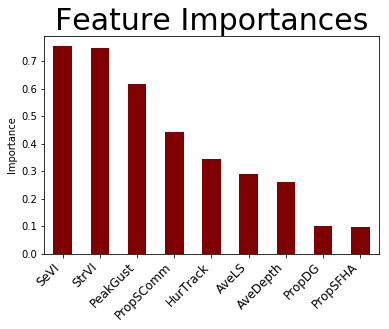

In [487]:
# EXAMPLE
permutation_importance_plot(mda_features, mda_importance)